# Seed templates poorly model sparse cells missed spike shape

author: steeve.laquitaine@epfl.ch

Method:  

0. engineering spike instance dataset with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'
1. choose a channel
2. find nearby ground truth cells (within 40 microns of the channel)

TODO:
- some missed cells seem to have detected spikes, which should not be the case. CHECK !
- make sure the true spike is detected and not noise. It seems to be the case some time (cell 165135). Detecting noise would affect interpretation in dimensionality reduction analyses.
- position raw template at its aligned position in column 1 of the figure to see where it best fits the signal.
- parametrize template_match with ms instead of timepoints

## Setup

Virtual env is `env_kilosort_silico`

You should have extracted the templates from a KS3 run by running `python3.9 -m src.pipes.postpro.univ_temp` in the terminal before. See usage in `univ_temp` module.


In [336]:
# SETUP PACKAGES 
%load_ext autoreload
%autoreload 2
import os 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(PROJ_PATH)


# SETUP PROJECT PACKAGE
from src.nodes.utils import get_config
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico import sorting
from src.pipes.postpro import univ_temp
from src.nodes.postpro import reduction
from src.nodes.postpro import template_matching as temp_match
from src.nodes.postpro.template_matching import get_rsquared
from src.nodes.postpro import spike_detection

# SET DATA PATH 
# whole campaign files
SPIKE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/spiketrains.pkl'
RAW_LFP_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/traces.pkl'
CELL_TRACE_FILE_PATH = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/dataeng/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/raw/cells/cell_3754013_trace.pkl'


# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/laquitai/sorting/0_silico/neuropixels_lfp_10m_2023_02_19/f3c730ef-8dd9-4d6d-8c18-3ddb7d3eeee7/campaign/study'
SAMPLING_FREQ = 10000 # sample/sec
EXAMPLE_CELL_ID = 4209594
EXAMPLE_CHANNEL_ID = 20
MS_BEFORE = 9  # duration of snippet portion extracted from recording before true timestamp (ms)
MS_AFTER = 9   # duration of snippet portion extracted from recording after true timestamp (ms)
SNIPPET_DURATION = 6 # duration of snippet to project (ms)
CELL_TYPE = "PYR"
LOAD_WAVEFORM_EXTRACTOR = False
LOAD_GROUND_TRUTH = True
LOAD_PREP_TRACE = True


# SET CHANNEL AND NEAREST CELLS
NEAREST_CHANNEL = 30
MISSED_CELL_IDS = [165135, 288502, 273515, 288502, 342702, 37423, 39862, 424433]
DETECTED_CELL_IDS = [19690, 367098]  


# SET CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET MODEL INPUT DATA PATHS
INSTANCE_FILE_PATH = data_conf["postprocessing"]["shape_study"]["instances"]
CHANNEL_IDS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["channel_ids"]
CELL_LABELS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["cell_labels"]
SPIKE_STATUS_FILE_PATH = data_conf["postprocessing"]["shape_study"]["spike_status"]
NEAREST_CHANNEL_FILE_PATH  = data_conf["postprocessing"]["shape_study"]["nearest_channel"]


# SET PLOT PARAMETERS
N_TOTAL_COLORS = 30
N_DETECTED_COLORS = 15
colors = np.array(sns.color_palette('tab10', n_colors=N_TOTAL_COLORS))
detected_colors = colors[:N_DETECTED_COLORS,]
missed_colors = colors[N_DETECTED_COLORS:,]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2023-05-26 14:12:29,355 - root - utils.py - get_config - INFO - Reading experiment config.
2023-05-26 14:12:29,379 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Load spike data

The dataset was engineered with '/gpfs/bbp.cscs.ch/data/project/proj68/home/laquitai/spike-sorting/notebooks/2_deepnet/0b_dataeng_neuropix_32.ipynb'

In [337]:
# load spike data
all_instances = pd.read_pickle(INSTANCE_FILE_PATH)
channel_ids = pd.read_pickle(CHANNEL_IDS_FILE_PATH)
cells = pd.read_pickle(CELL_LABELS_FILE_PATH)
spike_status = pd.read_pickle(SPIKE_STATUS_FILE_PATH)
nearest_channel = pd.read_pickle(NEAREST_CHANNEL_FILE_PATH)

## Load universal templates

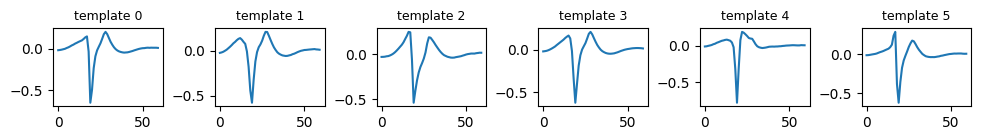

In [338]:
# plot
univ_templ = univ_temp.load(data_conf).T[:,:-1]

# setup plot
fig, axes = plt.subplots(1, len(univ_templ), figsize=(10,1.5))

n_templ = len(univ_templ)
for t_i in range(n_templ):
    axes[t_i].plot(univ_templ[t_i]);
    axes[t_i].set_title(f"template {t_i}", fontsize=9);
plt.tight_layout(w_pad=0)

## Template matching

Template alignment can position template far from ground truth spike timestamp, more so when spike snippet period is long, and other spikes occur within the period. To make sure that we capture the ground truth spike's signal and not noise or another spike, we selected the max explained variance of the template fit to the signal within a narrow window centered on the ground truth spike timestamp.

TODO:
- constrain the maximization of explained variance in a more restricted neighborhood (about the duration of a cell's refractory period, g., -/+1 ms) centered on the ground truth spike's timestamp to avoid extracting other spike signals, that would be better fitted than our target spike signal.

In [339]:
def plot_a_true_cell_spikes_by_detection_status(cell:int, nearest_channel:int, figsize:tuple, is_detected:bool):
    """_summary_

    Args:
        cell (int): _description_
        nearest_channel (int): _description_
        figsize (tuple, optional): _description_. Defaults to (6,3).

    Returns:
        _type_: _description_
    """

    # find its spikes
    detected_cell_loc = np.where((cells.values==cell) & (channel_ids.values==nearest_channel) & (spike_status.values==True))[0].tolist()
    spikes = all_instances.iloc[detected_cell_loc,:]

    # find its detected spikes
    out = spike_detection.get_true_unit_spikes_detection_status(cell, data_conf)
    detected_spikes = spikes.iloc[out["detection_status"].values==is_detected,:]
    
    # initialize
    template_fits = None
    explained_var = None
    shift = None
    fig = None
    
    # if there are detected spikes
    if not len(detected_spikes)==0:

        # fit template
        spikes, template_fits, explained_var, shift, fig = temp_match.template_match(
            detected_spikes,
            univ_templ[0],
            neighborhood=(6,9), 
            timepoints_before=30,
            timepoints_after=30,
            sampling_freq=10000,
            figsize=figsize).values()
    else:
        print("No spikes were detected for that cell")
    return {
        "spikes": spikes, 
        "template_fits": template_fits, 
        "explained_var": explained_var, 
        "shift": shift, 
        "fig": fig
        }

### Cell 1 - detected 

2023-05-26 14:12:32,824 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:12:32,833 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/spike_detection.py:172: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dict([(k, pd.Series(v)) for k, v in hits_dict.items()])


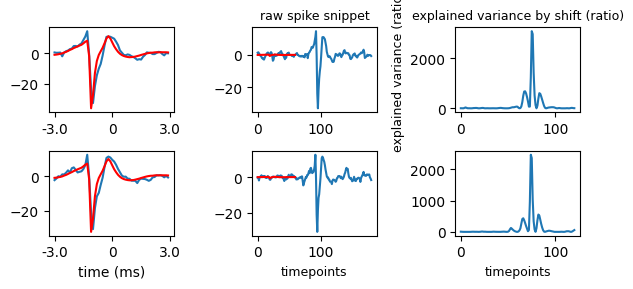

In [340]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(DETECTED_CELL_IDS[0], NEAREST_CHANNEL, figsize=(6,3), is_detected=True)

2023-05-26 14:12:34,052 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:12:34,062 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


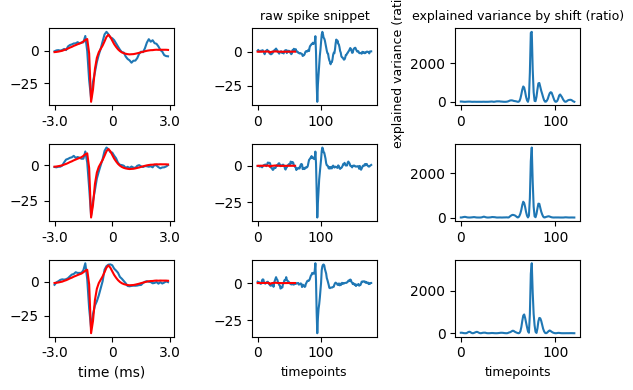

In [341]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(DETECTED_CELL_IDS[0], NEAREST_CHANNEL, figsize=(6,4), is_detected=False)

### Cell 2 - detected

2023-05-26 14:12:35,716 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:12:35,727 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


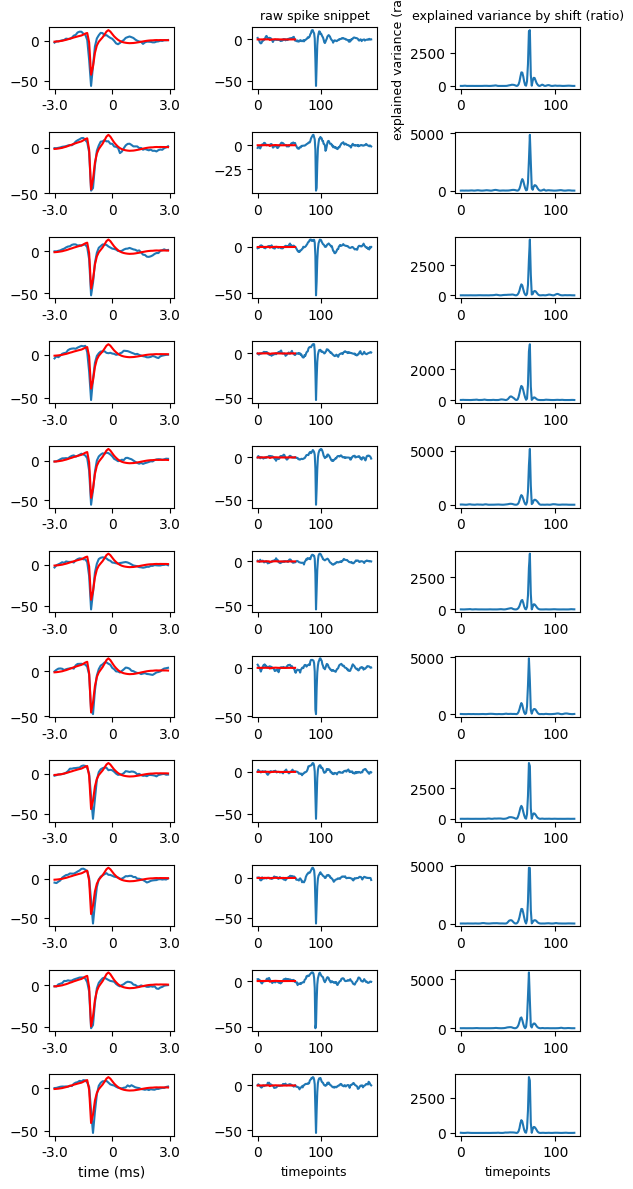

In [342]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(DETECTED_CELL_IDS[1], NEAREST_CHANNEL, figsize=(6,12), is_detected=True)

2023-05-26 14:12:40,236 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:12:40,246 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


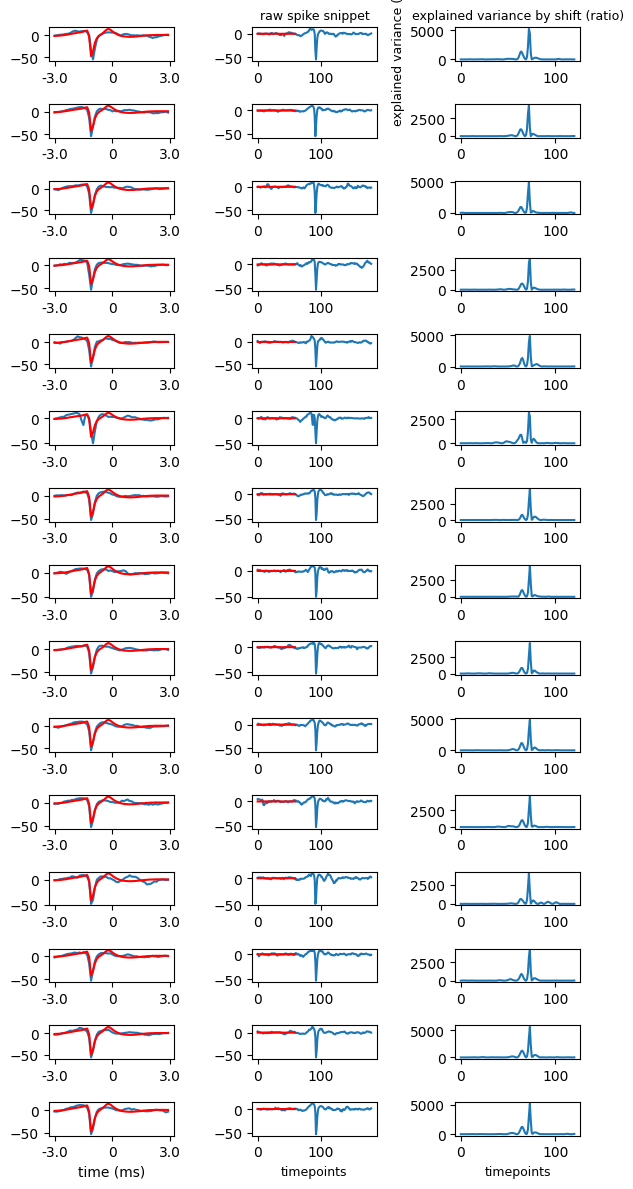

In [343]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(DETECTED_CELL_IDS[1], NEAREST_CHANNEL, figsize=(6,12), is_detected=False)

### Cell 3 - missed 

cell: 165135 

2023-05-26 15:04:45,319 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 15:04:45,346 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/nodes/postpro/spike_detection.py:172: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  dict([(k, pd.Series(v)) for k, v in hits_dict.items()])


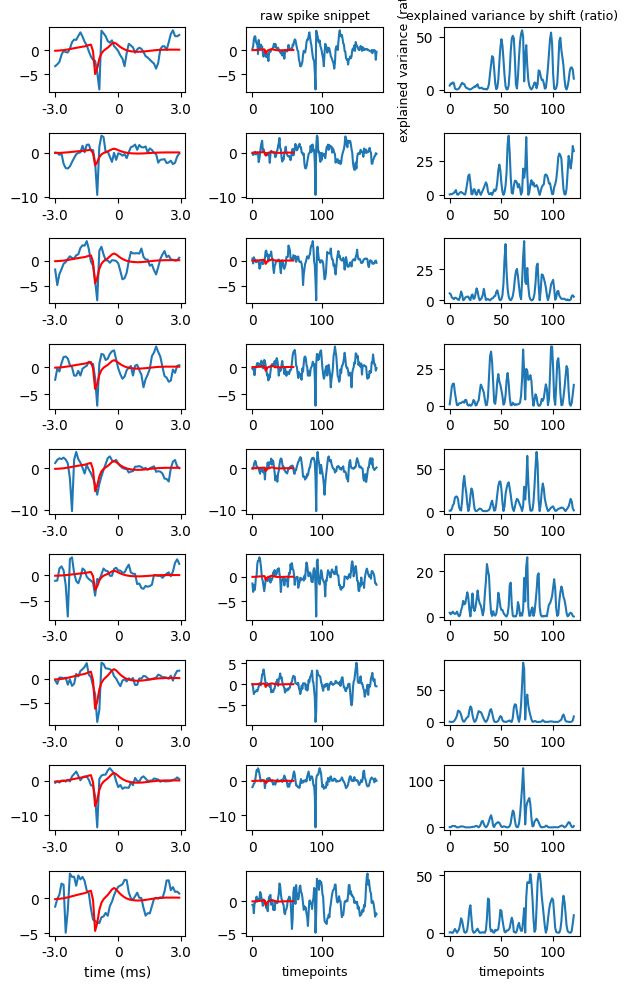

In [370]:
# plot detected spikes
print("cell:", MISSED_CELL_IDS[0], "\n")
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[0], NEAREST_CHANNEL, figsize=(6,10), is_detected=True)

2023-05-26 15:03:57,733 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 15:03:57,744 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


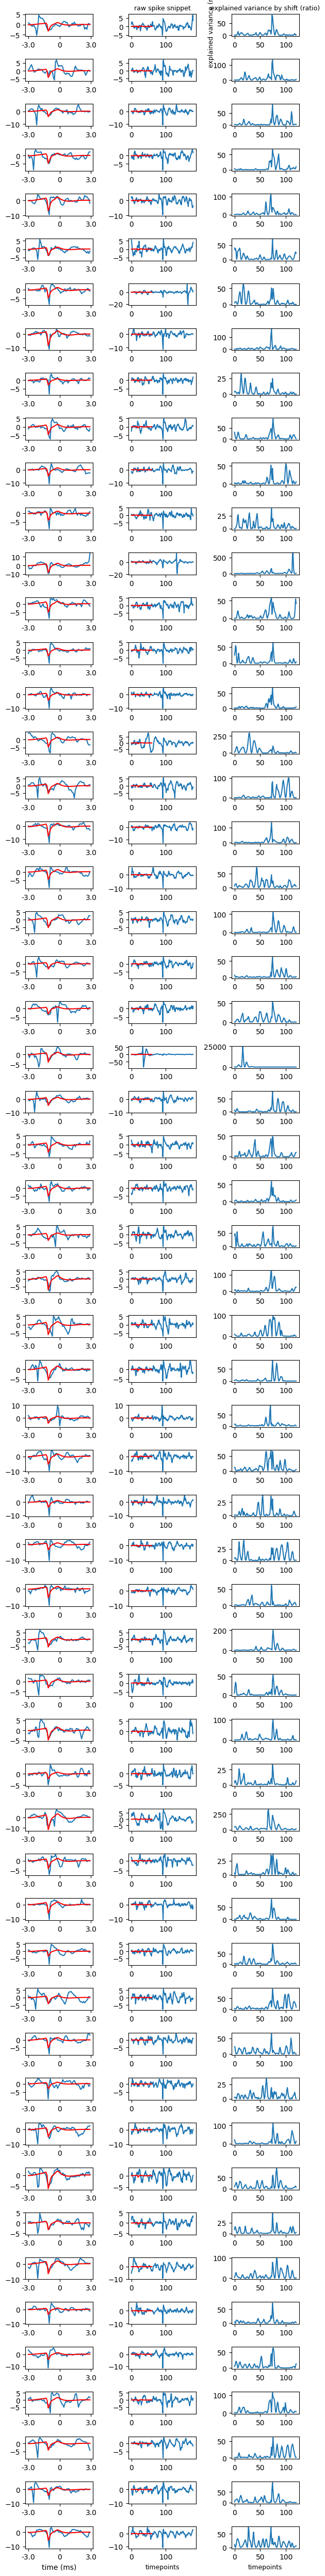

In [368]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[0], NEAREST_CHANNEL, figsize=(6,50), is_detected=False)

### Cell 4 - missed

In [346]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[1], NEAREST_CHANNEL, figsize=(6,10), is_detected=True)

2023-05-26 14:13:12,778 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:12,787 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
No spikes were detected for that cell


2023-05-26 14:13:13,061 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:13,070 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


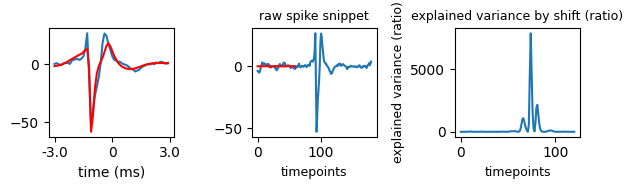

In [347]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[1], NEAREST_CHANNEL, figsize=(6,2), is_detected=False)

### Cell 5 - missed

2023-05-26 14:13:13,929 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:13,939 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


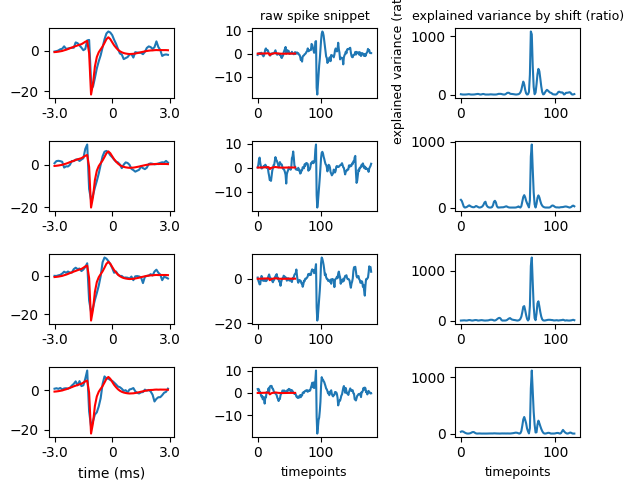

In [348]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[2], NEAREST_CHANNEL, figsize=(6,5), is_detected=True)

2023-05-26 14:13:16,179 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:16,190 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


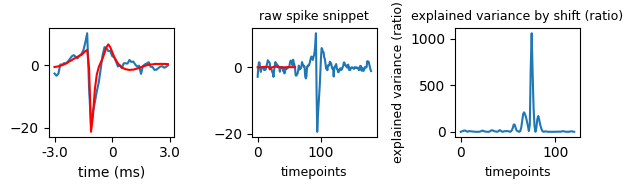

In [349]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[2], NEAREST_CHANNEL, figsize=(6,2), is_detected=False)

### Cell 6 - missed

In [350]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[3], NEAREST_CHANNEL, figsize=(6,5), is_detected=True)

2023-05-26 14:13:17,035 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:17,044 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
No spikes were detected for that cell


2023-05-26 14:13:17,310 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:17,319 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


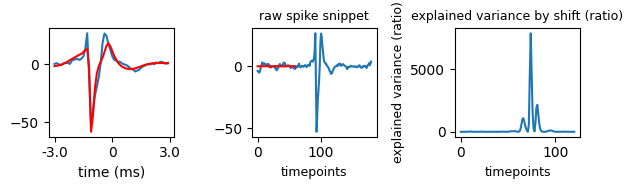

In [351]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[3], NEAREST_CHANNEL, figsize=(6,2), is_detected=False)

### Cell 7 - missed

2023-05-26 14:13:18,147 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:18,157 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


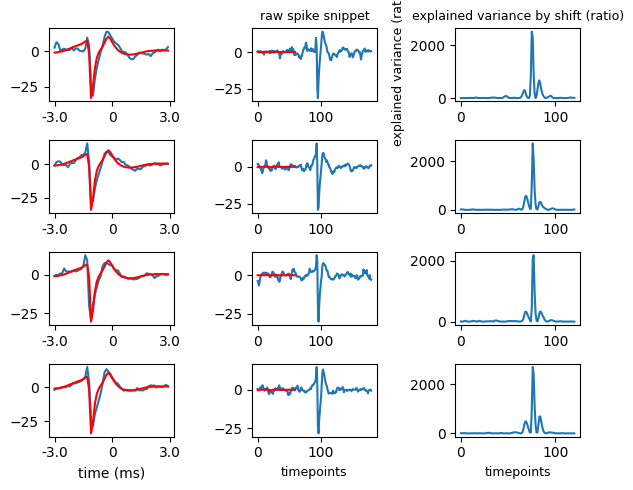

In [352]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[4], NEAREST_CHANNEL, figsize=(6,5), is_detected=True)

2023-05-26 14:13:20,127 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:20,138 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


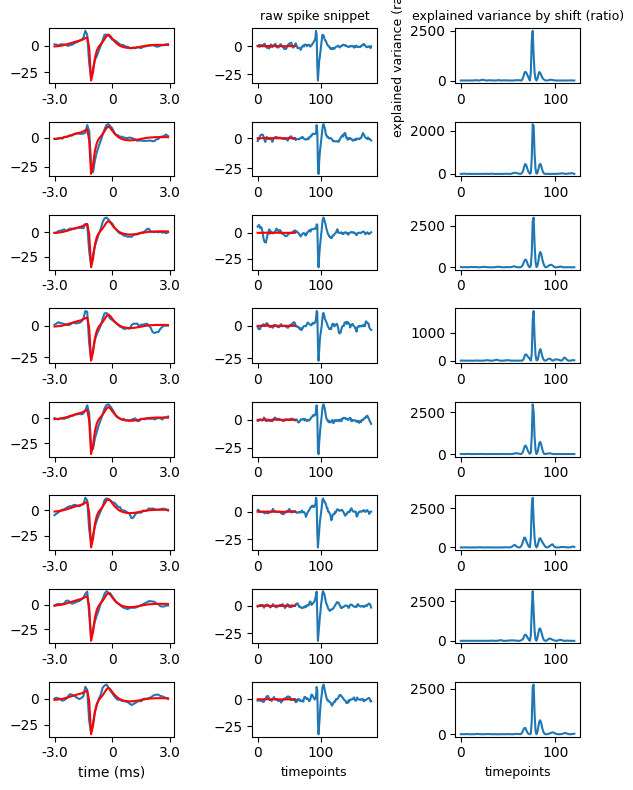

In [353]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[4], NEAREST_CHANNEL, figsize=(6,8), is_detected=False)

### Cell 8 - missed

2023-05-26 14:13:24,288 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:24,299 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


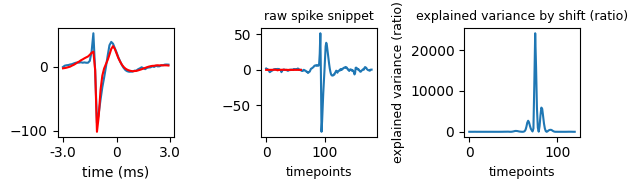

In [354]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[5], NEAREST_CHANNEL, figsize=(6,2), is_detected=True)

2023-05-26 14:13:25,368 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:25,380 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


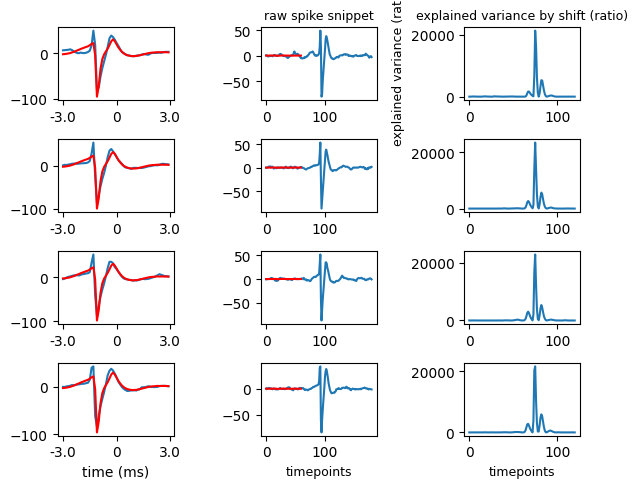

In [355]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[5], NEAREST_CHANNEL, figsize=(6,5), is_detected=False)

### Cell 9 - missed

2023-05-26 14:13:27,635 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:27,646 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


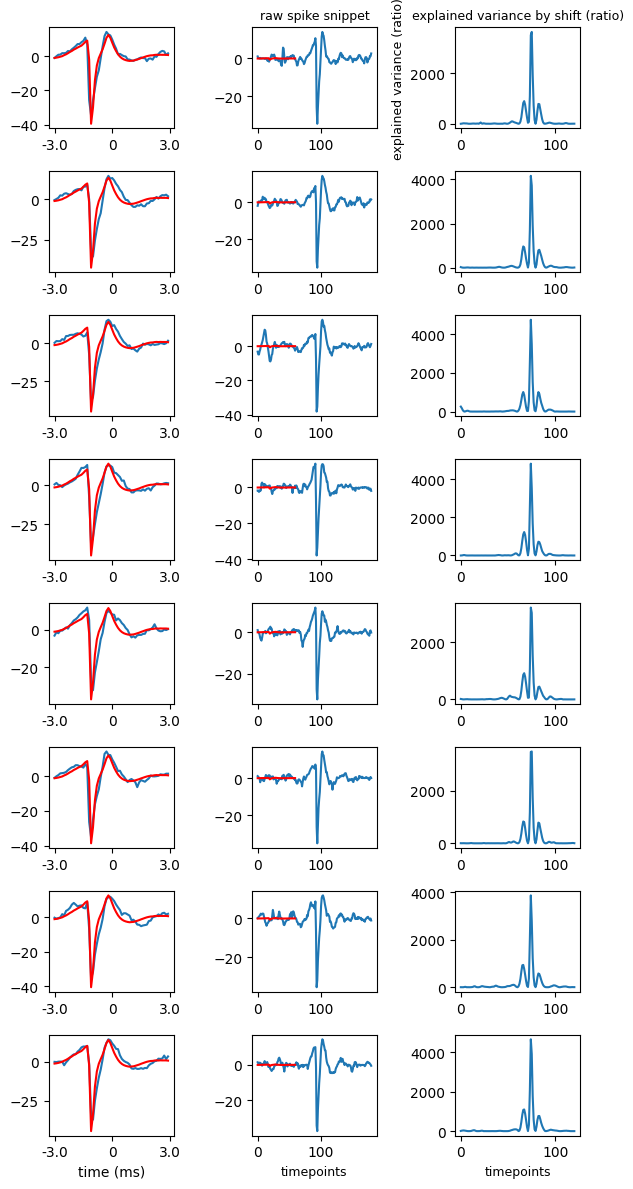

In [356]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[6], NEAREST_CHANNEL, figsize=(6,12), is_detected=True)

2023-05-26 14:13:31,019 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:31,029 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


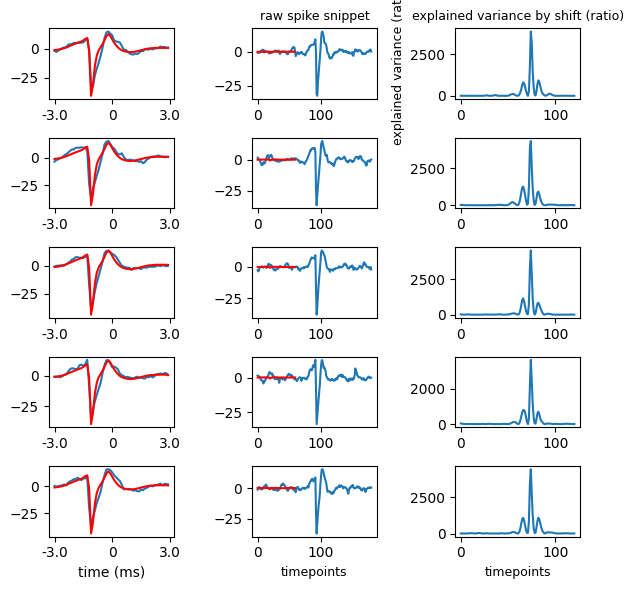

In [357]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[6], NEAREST_CHANNEL, figsize=(6,6), is_detected=False)

### Cell 10 - missed

2023-05-26 14:13:33,516 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:33,525 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0


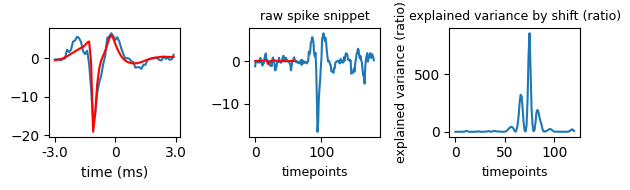

In [358]:
# plot detected spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[7], NEAREST_CHANNEL, figsize=(6,2), is_detected=True)

In [359]:
# plot missed spikes
out = plot_a_true_cell_spikes_by_detection_status(MISSED_CELL_IDS[7], NEAREST_CHANNEL, figsize=(6,6), is_detected=False)

2023-05-26 14:13:34,522 - root - ground_truth.py - load - INFO - loading already processed ground truth SortingExtractor ...
2023-05-26 14:13:34,531 - root - ground_truth.py - load - INFO - loading already processed true sorting - done in 0.0
No spikes were detected for that cell


# References

[A refresher on convolution and crosscorrelation](https://www.youtube.com/watch?v=C3EEy8adxvc)